In [10]:
import sys
from pathlib import Path

# Ensure repo root (with src/) is on sys.path
for candidate in [Path.cwd(), *Path.cwd().parents]:
    if (candidate / 'src').is_dir():
        sys.path.insert(0, str(candidate))
        break


CUDA available: True
Device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti
Epoch [10/100] Train Loss: 1.9032, Train Acc: 29.58%, Val Loss: 1.8708, Val Acc: 31.25%
Epoch [20/100] Train Loss: 1.7562, Train Acc: 34.50%, Val Loss: 1.7551, Val Acc: 35.75%
Epoch [30/100] Train Loss: 1.6704, Train Acc: 37.96%, Val Loss: 1.6999, Val Acc: 35.50%
Epoch [40/100] Train Loss: 1.5885, Train Acc: 41.00%, Val Loss: 1.6033, Val Acc: 40.50%
Epoch [50/100] Train Loss: 1.5333, Train Acc: 42.33%, Val Loss: 1.5870, Val Acc: 41.25%
Epoch [60/100] Train Loss: 1.4908, Train Acc: 44.50%, Val Loss: 1.5515, Val Acc: 44.50%
Epoch [70/100] Train Loss: 1.4239, Train Acc: 47.67%, Val Loss: 1.5731, Val Acc: 44.25%
Early stopping at epoch 77


/home/raul/Github/UM/UM_courses/Research_project/topology-and-robustness-in-DNNs/venv/lib/python3.10/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/home/raul/Github/UM/UM_courses/Research_project/topology-and-robustness-in-DNNs/venv/lib/python3.10/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/home/raul/Github/UM/UM_courses/Research_project/topology-and-robustness-in-DNNs/venv/lib/python3.10/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/home/raul/Github/UM/UM_courses/Research_project/topology-and-robustness-in-DNNs/venv/lib/python3.10/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/home/raul/Github/UM/UM_

ROC AUC: 0.513996212121212
AUPRC: 0.27697922363639305
CPU times: user 8min 14s, sys: 9.16 s, total: 8min 23s
Wall time: 6min 4s


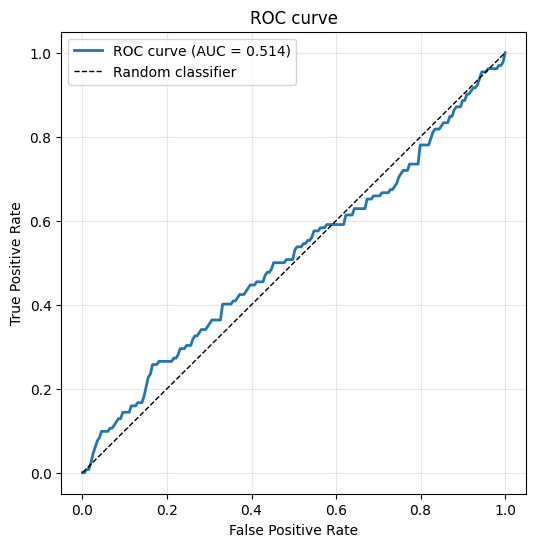

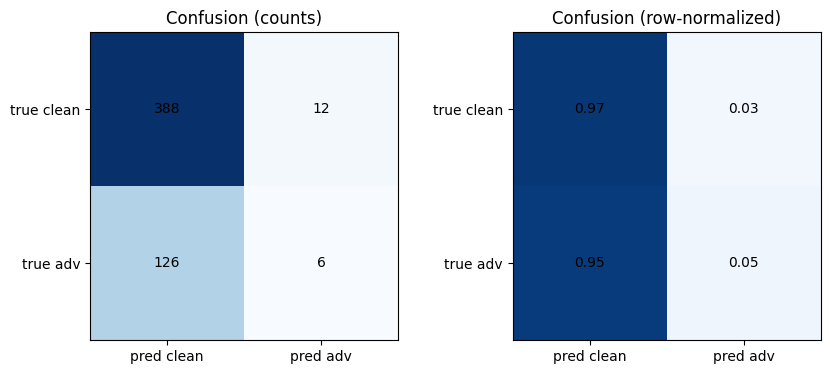

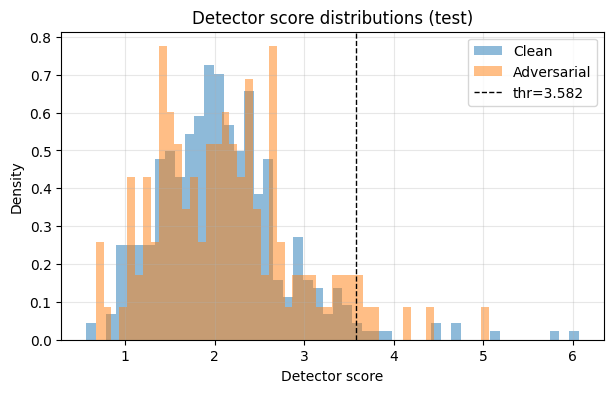

In [11]:
%%time
from src import ExperimentConfig, run_pipeline, get_dataset
from src.data import DATASET_REGISTRY, DatasetBundle
import numpy as np

cfg = ExperimentConfig()

import torch
print("CUDA available:", torch.cuda.is_available())
cfg.device = "cuda"
print("Device:", cfg.device)
if cfg.device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

cfg.data.root = "./data"          # dove vuoi CIFAR10
cfg.data.download = True          # metti False se li hai gia
cfg.graph.space = "feature"
cfg.graph.use_topology = True
cfg.model.epochs = 100
cfg.model.batch_size = 128
cfg.model.device = "cuda"
cfg.attack.attack_type = "fgsm"
cfg.attack.epsilon = 0.03
cfg.attack.num_steps = 20
cfg.attack.step_size = 0.007
cfg.model.learning_rate = 0.001
cfg.model.weight_decay = 0.0001
cfg.model.patience = 30

# Crea un sottoinsieme piccolo di CIFAR10
class CIFAR10Small:
    def load(self, cfg):
        b = get_dataset("cifar10", cfg)
        rng = np.random.default_rng(cfg.seed)

        def sub(X, y, n):
            idx = rng.choice(len(X), size=n, replace=False)
            return X[idx], y[idx]

        X_train, y_train = sub(b.X_train, b.y_train, 2400)
        X_val, y_val = sub(b.X_val, b.y_val, 400)
        X_test, y_test = sub(b.X_test, b.y_test, 400)
        return DatasetBundle(X_train, y_train, X_val, y_val, X_test, y_test, b.meta)

DATASET_REGISTRY["cifar10_small"] = CIFAR10Small()

result = run_pipeline(
    dataset_name="cifar10_small",
    model_name="minicnn",
    cfg=cfg,
    model_kwargs={"in_channels": 3, "num_classes": 10},
    eval_only_successful_attacks = True, 
    max_points_for_scoring=1000,  # opzionale per velocizzare
)

print("ROC AUC:", result.eval.metrics["roc_auc"])
print("AUPRC:", result.eval.metrics["pr_auc"])


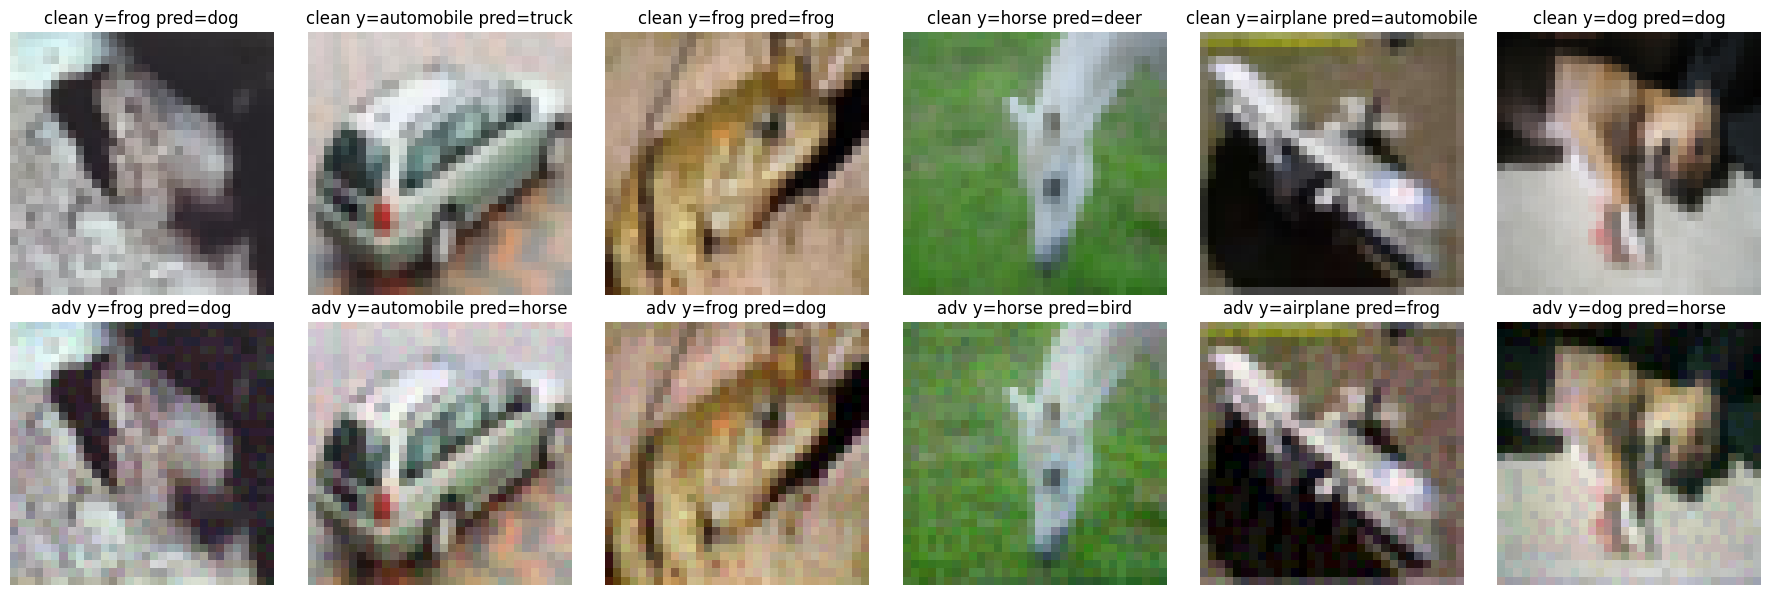

In [12]:
# Clean vs adversarial (CIFAR10)
import numpy as np
import matplotlib.pyplot as plt
from src.models import get_model_predictions

CIFAR10_CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

if result.attack_test is None:
    print("No attack_test available in result.")
else:
    X_clean = result.bundle.X_test
    X_adv = result.attack_test.X_adv
    y = result.bundle.y_test

    n = min(6, len(X_clean))
    rng = np.random.default_rng(42)
    idx = rng.choice(len(X_clean), size=n, replace=False)

    device = str(result.cfg.device)
    y_pred_clean = get_model_predictions(result.model, X_clean[idx], device=device, return_probs=False)
    y_pred_adv = get_model_predictions(result.model, X_adv[idx], device=device, return_probs=False)

    fig, axes = plt.subplots(2, n, figsize=(3 * n, 6))
    if n == 1:
        axes = np.array([[axes[0]], [axes[1]]])

    for i, j in enumerate(idx):
        img_c = np.transpose(X_clean[j], (1, 2, 0))
        img_a = np.transpose(X_adv[j], (1, 2, 0))

        true_name = CIFAR10_CLASSES[int(y[j])]
        pred_clean_name = CIFAR10_CLASSES[int(y_pred_clean[i])]
        pred_adv_name = CIFAR10_CLASSES[int(y_pred_adv[i])]

        axes[0, i].imshow(img_c)
        axes[0, i].set_title(f"clean y={true_name} pred={pred_clean_name}")
        axes[1, i].imshow(img_a)
        axes[1, i].set_title(f"adv y={true_name} pred={pred_adv_name}")

        axes[0, i].axis("off")
        axes[1, i].axis("off")

    plt.tight_layout()
